<a href="https://colab.research.google.com/github/kylematoba/deeplearning-project/blob/master/keras_wide_res_net_matoba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip3 install funcy
!git clone https://github.com/tensorflow/models.git
!git clone https://github.com/modestyachts/CIFAR-10.1.git  # Recht 2018 data

fatal: destination path 'models' already exists and is not an empty directory.
fatal: destination path 'CIFAR-10.1' already exists and is not an empty directory.


In [0]:
import os
import sys
import shutil
import pickle
import copy
import functools
import logging

from typing import Any, Callable, List, Tuple, Union
from operator import getitem, attrgetter
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import ImageOps
from PIL import ImageEnhance
from PIL import ImageFilter
from PIL import Image

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input, Layer
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from funcy import concat, identity, juxt, partial, rcompose, repeat, repeatedly, take

from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

import models.research.autoaugment.augmentation_transforms as augmentation_transforms

In [28]:
FORMAT = "%(asctime)s %(process)s %(thread)s: %(message)s"
logging.basicConfig(level=logging.DEBUG, format=FORMAT, stream=sys.stdout)
logger = logging.getLogger(__name__)

environ_dict = dict(os.environ)
use_tpu = 'COLAB_TPU_ADDR' in environ_dict.keys()

logger.info(sys.version)
logger.info("{}".format("Running in ipython" if 'ipykernel' in sys.modules else ""))
logger.info("Numpy version {}".format(np.__version__))
logger.info("TensorFlow version {}".format(tf.__version__))
if use_tpu:
    logger.info("Running on TPU")

2018-12-05 19:19:57,183 69 139803676686208: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
2018-12-05 19:19:57,185 69 139803676686208: Running in ipython
2018-12-05 19:19:57,187 69 139803676686208: Numpy version 1.14.6
2018-12-05 19:19:57,189 69 139803676686208: TensorFlow version 1.12.0
2018-12-05 19:19:57,191 69 139803676686208: Running on TPU


In [0]:
np.random.seed(0)

In [0]:
def download_data() -> None:
    url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    shutil.copytree(tf.keras.utils.get_file('cifar-10-batches-py', origin=url, untar=True), './data')

    
def load_batch(batch_path: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(batch_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data_np = np.array(batch[b'data'])
    labels_np = np.array(batch[b'labels'])
    batch_data = data_np.reshape(data_np.shape[0], 3, 32, 32).transpose(0, 2, 3, 1) / 255
    batch_labels = tf.keras.utils.to_categorical(labels_np)
    return (batch_data, batch_labels)


def load_batches(paths: List[str]):
    return tuple(map(np.concatenate, zip(*map(load_batch, paths))))


def load_data(data_path='./data') -> Tuple[np.ndarray, np.ndarray]:
    if not os.path.exists('./data'):
        download_data()
    paths = sorted(map(attrgetter('path'), filter(lambda directory_entry: directory_entry.name.startswith('data_batch_'), os.scandir(data_path))))
    xy_train = load_batches(paths)
    xy_validation = load_batch('{0}/test_batch'.format(data_path))
    return (xy_train, xy_validation)

In [0]:
# A modified version of https://github.com/tail-island/try-wide-residual-net
def computational_graph(class_size):
    def ljuxt(*fs):
        return rcompose(juxt(*fs), list)

    def batch_normalization():
        return BatchNormalization()

    def relu() -> tf.keras.layers.Activation:
        return Activation('relu')

    def conv(filter_size: int, kernel_size: int, stride_size: int=1) -> Layer:
        return Conv2D(filter_size, kernel_size, strides=stride_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), use_bias=False)

    def add():
        return Add()

    def global_average_pooling():
        return GlobalAveragePooling2D()

    def dense(units: int, activation: str) -> Layer:
        return Dense(units, activation=activation, kernel_regularizer=l2(0.0005))

    # Define WRN-28-10.
    def first_residual_unit(filter_size: int, stride_size: int):
        return rcompose(batch_normalization(),
                        relu(),
                        ljuxt(rcompose(conv(filter_size, 3, stride_size),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3, 1)),
                              rcompose(conv(filter_size, 1, stride_size))),
                        add())

    def residual_unit(filter_size):
        return rcompose(ljuxt(rcompose(batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3)),
                              identity),
                        add())

    def residual_block(filter_size, stride_size, unit_size):
        return rcompose(first_residual_unit(filter_size, stride_size),
                        rcompose(*repeatedly(partial(residual_unit, filter_size), unit_size - 1)))

    k = 10
    n =  4
    return rcompose(conv(16, 3),
                    residual_block(16 * k, 1, n),
                    residual_block(32 * k, 2, n),
                    residual_block(64 * k, 2, n),
                    batch_normalization(),
                    relu(),
                    global_average_pooling(),
                    dense(class_size, 'softmax'))

In [0]:
(x_train, y_train), (x_validation, y_validation) = load_data()

In [0]:
# This is a super heavily modified version of: https://github.com/Zahlii/colab-tf-utils
GDriveItem = namedtuple('GDriveItem', ['name', 'fid'])  # A Folder or File in your Google Drive
EpochData = namedtuple('EpochData', ['epoch', 'losses'])  # Epoch information as returned from keras


class GDriveSync:
    # Simple up/downloading functionality to move local files into the cloud and vice versa.
    def __init__(self):
        auth.authenticate_user()  # prompt the user to access his Google Drive via the API
        self.drive_service = build('drive', 'v3')
        self.default_folder = self.find_items('Colab Notebooks')[0]

    def find_items(self, name: str) -> List[str]:
        """
        Find folders or files based on their name. This always searches the full Google Drive tree!
        :param name: Term to be searched. All files containing this search term are returned.
        """
        folder_list = self.drive_service.files().list(q='name contains "%s"' % name).execute()
        folders = []
        for folder in folder_list['files']:
            folders.append(GDriveItem(folder['name'], folder['id']))
        return folders

    def upload_file_to_folder(self, local_file: str, folder=None) -> None:
        """
        Upload a local file, optionally to a specific folder in Google Drive
        :param local_file: Path to the local file
        :param folder: (Option) GDriveItem which should be the parent.
        """
        if folder is not None:
            assert type(folder) == GDriveItem	

        file_metadata = {
            'title': local_file,
            'name': local_file
        }

        if folder is not None:
            file_metadata['parents'] = [folder.fid]

        media = MediaFileUpload(local_file, resumable=True)
        created = self.drive_service.files().create(body=file_metadata,
                                                    media_body=media,
                                                    fields='id')
        if folder is not None:
            d = 'Uploading file %s to folder %s' % (local_file, folder.name)
        else:
            d = 'Uploading file %s' % local_file

        response = None
        while response is None:
            status, response = created.next_chunk()
                
    def download_file_to_folder(self, 
                                remote_file: GDriveItem, 
                                path: str) -> None:
        assert type(remote_file) == GDriveItem
        request = self.drive_service.files().get_media(fileId=remote_file.fid)

        with open(path, 'wb') as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()

    def delete_file(self, file: GDriveItem) -> None:
        assert type(file) == GDriveItem
        request = self.drive_service.files().delete(fileId=file.fid)
        request.execute()


class GDriveCheckpointer(tf.keras.callbacks.Callback):
    """
    Keras Callback that automatically saves models into your Google Drive.
    Outdated checkpoints are automatically deleted remotely to prevent GDrive from filling up.
    Checkpointing is controlled by two functions:
        compare_fn(best_epoch: EpochData, current_epoch: EpochData) -> bool
        - If this function returns true, the current_epoch is assumed to have better performance than the older best_epoch.
        - e.g. return best_epoch.losses['val_acc'] < current_epoch.losses['val_acc']
        filepath_fn(epoch: EpochData) -> Union[String, None]
        - If this function returns None, the checkpoint is skipped. This can be used to skip backing up early epochs.
          If it returns a String path, the model is uploaded into the default GDrive folder with the given file name.
    """
    def __init__(self, 
                 compare_fn: Callable, 
                 filepath_fn: Callable, 
                 save_optimizer=False):
        assert compare_fn is not None, 'Need a compare function which gets all the losses and evaluation data of two epochs and which needs to return True if the second one is better.'
        assert filepath_fn is not None, 'Need a function that derives a file path based on a dictionary of losses and metrics.'

        restart_from_backup = False
        super(GDriveCheckpointer, self).__init__()
        self.saver = GDriveSync()
        self.compare_fn = compare_fn
        self.filepath_fn = filepath_fn
        self.best_epoch = None
        self.best_filename = None
        self.save_optimizer = save_optimizer

    def on_epoch_end(self, epoch: int, logs={}):
        losses = dict(logs)
        epoch_data = EpochData(epoch, losses)
        if self.best_epoch is None or self.compare_fn(self.best_epoch, epoch_data):
            self.best_epoch = copy.deepcopy(epoch_data)
            fn = self.filepath_fn(epoch_data)
            if fn is not None and fn:
                if self.best_filename:
                    os.remove(self.best_filename)
                    all_found = self.saver.find_items(self.best_filename)
                    old_file = all_found[0]
                    print('Removing old cloud file %s' % old_file.name)
                    self.saver.delete_file(old_file)
                self.best_filename = fn
                self._save_checkpoint()
            else:
                print('Skipping upload because path function returned no path.')
        else:
            pass

    def _save_checkpoint(self):
        print('Saving {}'.format(self.best_filename))
        self.model.save(self.best_filename)
        print('Uploading to {}'.format(self.saver.default_folder))
        self.saver.upload_file_to_folder(self.best_filename, self.saver.default_folder)
        

In [0]:
def filepath_fn_unbound(filebase: str, 
                        x: EpochData) -> Union[str, None]:
    filepath = '{}_{:04d}'.format(filebase, x.epoch)
    return filepath
  

def compare_fn(best_epoch: EpochData, 
               current_epoch: EpochData) -> bool:
    save_every = 10
    save = 0 == current_epoch.epoch % save_every
    return save
  

# filebase = 'wide_res_net'
# filebase = 'autoaugment'
# filebase = 'jonathan'
filebase = 'jesse'
filepath_fn = lambda x: filepath_fn_unbound(filebase, x)

In [35]:
# this one prompts for authorisation
gdcp = GDriveCheckpointer(compare_fn, filepath_fn)
# gdcp

2018-12-05 19:20:00,536 69 139803676686208: Making request: POST https://accounts.google.com/o/oauth2/token
2018-12-05 19:20:00,541 69 139803676686208: Starting new HTTPS connection (1): accounts.google.com
2018-12-05 19:20:00,596 69 139803676686208: https://accounts.google.com:443 "POST /o/oauth2/token HTTP/1.1" 200 None
2018-12-05 19:20:00,602 69 139803676686208: file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'o

In [36]:
def get_last_filename(filebase: str) -> str:
    remote_files = gdcp.saver.find_items(filebase)
    sorted_filenames = sorted([x.name for x in remote_files])
    if len(sorted_filenames) > 0:
        last_filename = sorted_filenames[-1]
    else:
        last_filename = None
    return last_filename

attempt_reload_from_drive = True
last_filename = get_last_filename(filebase)

if attempt_reload_from_drive and (last_filename is not None):
    remote_files = gdcp.saver.find_items(last_filename)
    remote_file = remote_files[0]
    local_best_model_fn = remote_file.name
    logger.info("Loading from {}".format(local_best_model_fn))
    gdcp.saver.download_file_to_folder(remote_file, local_best_model_fn)
    model = load_model(local_best_model_fn)
    initial_epoch = int(remote_file.name.split('_')[-1])
else:
    xshape = x_train.shape[1:]
    yshape = y_train.shape[1]
    model = Model(*juxt(identity, computational_graph(yshape))(Input(shape=xshape)))
    optimizer = SGD(momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # nesterov=True
    initial_epoch = 0

2018-12-05 19:20:01,066 69 139803676686208: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22jesse%22&alt=json
2018-12-05 19:20:02,327 69 139803676686208: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22jesse_0120%22&alt=json
2018-12-05 19:20:02,588 69 139803676686208: Loading from jesse_0120
2018-12-05 19:20:02,592 69 139803676686208: URL being requested: GET https://www.googleapis.com/drive/v3/files/1A6yWDU0mr2yYIzWHFc-9Is6Dea5NRZfC?alt=media


In [37]:
remote_files = gdcp.saver.find_items(filebase)
sorted_filenames = sorted([x.name for x in remote_files])
if len(sorted_filenames) > 0:
    last_filename = sorted_filenames[-1]
else:
    last_filename = None

2018-12-05 19:20:15,152 69 139803676686208: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22jesse%22&alt=json


In [0]:
# https://software.intel.com/en-us/articles/hands-on-ai-part-14-image-data-preprocessing-and-augmentation
def return_good_policies() -> List[tuple]:
    """AutoAugment policies found on analysis."""
    if filebase == 'jonathan':
        exp0_0 = [
          [('FlipLR', 0.5, 5)],
          [('TranslateY', 0.5, 5)],
          [('TranslateX', 0.5, 5)],
          [('ShearY', 0.5, 5)],
          [('Solarize', 0.5, 5)],
          [('Rotate', 0.5, 5)]
        ]
    elif filebase == 'jesse':
        exp0_0 = [
          [('Sharpness', 0.4, 5)],
          [('Color', 0.2, 5)],
          [('ShearY', 0.6, 5)],
          [('Sharpness', 0.0, 5)],
          [('Brightness', 0.6, 5)]
        ]
    else:
        exp0_0
    return exp0_0


good_policies = return_good_policies()
batch_size = 128
checkpoint_period = 10

    
def autoaugment(x: np.ndarray) -> np.ndarray:
    epoch_policy = good_policies[np.random.choice(len(good_policies))]
    x = augmentation_transforms.apply_policy(epoch_policy, x)
    return x
  

if filebase == 'jonathan' or filebase == 'autoaugment' or filebase == 'jesse':
    def preprocessing_function(x: np.ndarray) -> np.ndarray:
        x = autoaugment(x)
        x = augmentation_transforms.random_flip(augmentation_transforms.zero_pad_and_crop(x, 4))
        x = augmentation_transforms.cutout_numpy(x)
        return x

    horizontal_flip = False
    width_shift_range = 0.0
    height_shift_range = 0.0
    epochs = 300
elif filebase == 'wide_res_net':
    def preprocessing_function(x: np.ndarray) -> np.ndarray:
        return x
    epochs = 200
    width_shift_range = 0.125
    height_shift_range = 0.125
    horizontal_flip = True

In [0]:
# import models.research.autoaugment.augmentation_transforms as augmentation_transforms

Text(0.5,1,"['ship']")

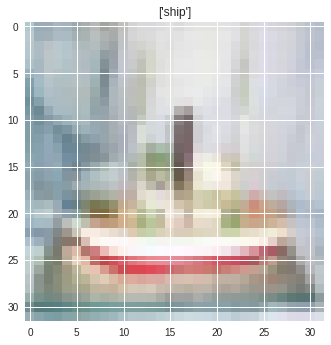

In [40]:
CLASS_LABELS = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

train_set_size = x_train.shape[0]
# idx = 1000
idx = np.random.randint(train_set_size)
# idx = 2395
label = CLASS_LABELS[y_train[idx, :].astype(bool)]
plt.imshow(x_train[idx, :, :, :])
plt.title(label)


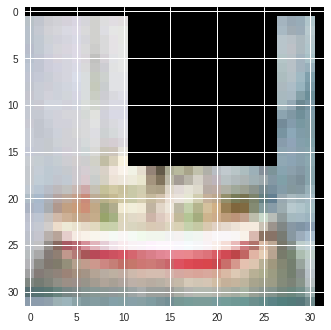

In [41]:
# !ls models/research/autoaugment
plt.imshow(preprocessing_function(x_train[idx, :, :, :]))

In [42]:
if use_tpu:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    using_single_core = False
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
    strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu_cluster_resolver, using_single_core=using_single_core)
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

train_data = ImageDataGenerator(featurewise_center=True, 
                                featurewise_std_normalization=True, 
                                width_shift_range=width_shift_range, 
                                height_shift_range=height_shift_range, 
                                horizontal_flip=horizontal_flip,
                                preprocessing_function=preprocessing_function)
validation_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

for data in (train_data, validation_data, test_data):
    data.fit(x_train)

learning_rate_callback = LearningRateScheduler(partial(getitem, tuple(take(epochs, concat(repeat(0.1, 60), repeat(0.02, 60), repeat(0.004, 40), repeat(0.0008))))))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks = [gdcp, learning_rate_callback]

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.67.174.146:8470') for TPU system metadata.
2018-12-05 19:20:15,840 69 139803676686208: Querying Tensorflow master (b'grpc://10.67.174.146:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
2018-12-05 19:20:15,853 69 139803676686208: Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
2018-12-05 19:20:15,855 69 139803676686208: *** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
2018-12-05 19:20:15,858 69 139803676686208: *** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
2018-12-05 19:20:15,861 69 139803676686208: *** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5517903950363257)
2018-12-05 19:20:15,863 69 139803676686208: *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5517903950363257)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worke

In [0]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)

steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_validation.shape[0] // batch_size

results = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              initial_epoch=initial_epoch,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 121/300
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_1_30'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_target_70')]
2018-12-05 19:20:52,665 69 139803676686208: New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_1_30'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_target_70')]
INFO:tensorflow:Overriding default placeholder.
2018-12-05 19:20:52,715 69 139803676686208: Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.004000000189989805, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
2018-12-05 19:20:57,015 69 139803676686208: Cloning SGD {'lr': 0.004000000189989805, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
IN

In [0]:
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:

cifar101_data = np.load('CIFAR-10.1/datasets/cifar10.1_v6_data.npy')
cifar101_labels = np.load('CIFAR-10.1/datasets/cifar10.1_v6_labels.npy')
cifar101_set_size = len(cifar101_labels)
  
y_test = tf.keras.utils.to_categorical(cifar101_labels)
x_test = cifar101_data / 255

In [0]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)
test_generator = test_data.flow(x_test, y_test, batch_size=batch_size)

loss, acc = model.evaluate_generator(train_generator)
logger.info("Train: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(validation_generator)
logger.info("Validation: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(test_generator)
logger.info("Test: Loss={}, acc={}".format(loss, acc))

In [0]:
test_set_size = x_test.shape[0]
idx = np.random.randint(test_set_size)
# idx = 1113
label = CLASS_LABELS[y_test[idx, :].astype(bool)]
tit = "{}: {}".format(idx, label)
plt.figure(figsize=(3,4))
plt.imshow(x_test[idx, :, :, :])
plt.title(tit)

In [0]:
predictions = model.predict(x=x_test)

In [0]:
from collections import Counter
_ = np.argmax(predictions, axis=1)
Counter(_)
Counter(cifar101_labels)

In [0]:
checkpoint_dir 
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
!ls -ltra $checkpoint_dir

In [0]:
# with open('./results/history.pickle', 'wb') as f:
#     pickle.dump(results.history, f)

# save_model(model, './results/model.h5')
# del model